In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

import joblib

from sklearn.inspection import plot_partial_dependence

# Function

In [2]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val
def plot_cm(cm_val, save=False, title="-", split="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title+" {}".format(split), fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(save, split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')  
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
def predict_set(split,param):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    loaded_model = joblib.load('RF_model/RF_param{}_{}.joblib'.format(param,split))
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    return y_val, y_pred_val, y_pred_val_raw
def ROC_split(param):
    split = "split1"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split2"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc2 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split3"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr3, tpr3, thr3 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc3 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split4"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr4, tpr4, thr4 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc4 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split5"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr5, tpr5, thr5 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc5 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc3)
    print("AUC split4: %.2f%%" % auc4)
    print("AUC split5: %.2f%%" % auc5)
    
    plt.plot(fpr1,tpr1,label="ROC split 1, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC split 2, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr3,tpr3,label="ROC split 3, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr4,tpr4,label="ROC split 4, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr5,tpr5,label="ROC split 5, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

def feature_impotance(split):
    loaded_model = joblib.load('RF_model/RF_{}.joblib'.format(split))
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    # get the best random forest model
    best_rfc = loaded_model.best_estimator_
    # get the feature importances of the best random forest model
    importances = best_rfc.feature_importances_
    df = pd.DataFrame({'Variable':x_train.columns,
              'Importance':importances}).sort_values('Importance', ascending=False)
    indices = df.index
    top_feature = df.iloc[0]['Variable']
    second_feature = df.iloc[1]['Variable']
    print("The most important feature in split {} is: {}".format(split, top_feature))
    plt.figure(figsize=(12,6))
    plt.title("Feature Importances")
    plt.bar(range(x_train.shape[1]), importances[indices])
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
    plt.show()
    return top_feature, second_feature
    
def false_predict(y_true, y_pred, split="test"):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    false_positive = []
    false_negative = []
    if split == "test":
        test_path =  "{}/test.csv".format(path)
        test_data = pd.read_csv(test_path)
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = test_data.loc[false_positive]
        false_negative_df = test_data.loc[false_negative]
        M_data = test_data[test_data["diagnosis"]=="M"]
        B_data = test_data[test_data["diagnosis"]=="B"]
    elif "split" in split:
        val_path =  "{}/{}/val/val.csv".format(path,split)
        val_data = pd.read_csv(val_path)
        false_indices = []
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = val_data.loc[false_positive]
        false_negative_df = val_data.loc[false_negative]
        M_data = val_data[val_data["diagnosis"]=="M"]
        B_data = val_data[val_data["diagnosis"]=="B"]
    x_col, y_col = feature_impotance(split)
    # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
    plt.scatter(B_data[x_col], B_data[y_col], color='green', label='B', alpha=0.5)
    plt.scatter(M_data[x_col], M_data[y_col], color='blue', label='M', alpha=0.5)
    plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='red', label='False Negative Predictions')
    plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='orange', label='False Positive Predictions') 
    # Add legend and labels
    plt.legend()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Show the plot
    plt.show()
    
#     # create a joint plot with a regression line
#     jp = sns.jointplot(x[x_col], x[y_col], kind='reg', data=df)

#     # add distribution plots
#     sns.histplot(x[x_col], ax=jp.ax_marg_x, color='purple')
#     sns.histplot(x[y_col], ax=jp.ax_marg_y, color='orange')

#     # set x and y labels
#     jp.set_axis_labels(x_col, y_col)

#     # show the plot
#     plt.show()

    return false_indices
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))
def evaluate(param,split):
    loaded_model = joblib.load('RF_model/RF_param{}_{}.joblib'.format(param,split))
    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, title="Validate", split=split)
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test, title="Test", split=split)

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    print("false_predict")
    false_predict(y_val, y_pred_val,split)
    return cm_val,cm_test,auc1,auc2

# split 1

../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.547500
FPR: 0.0351
TPR: 0.9118
Confusion Matrix
----------------
[[55  2]
 [ 3 31]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 96.49%
Accuracy: 94.51%
Precision: 93.94%
Sensitivity: 91.18%
Precision: 93.94%
F1: 92.54%


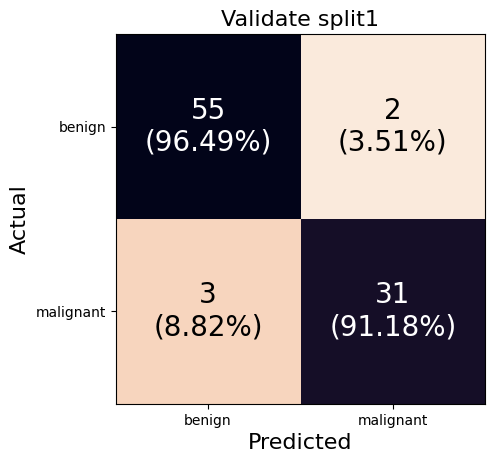

################# test set ##################
Best Threshold=0.387500
FPR: 0.0278
TPR: 1.0000
Confusion Matrix
----------------
[[70  2]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 98.25%
Precision: 95.45%
Sensitivity: 100.00%
Precision: 95.45%
F1: 97.67%


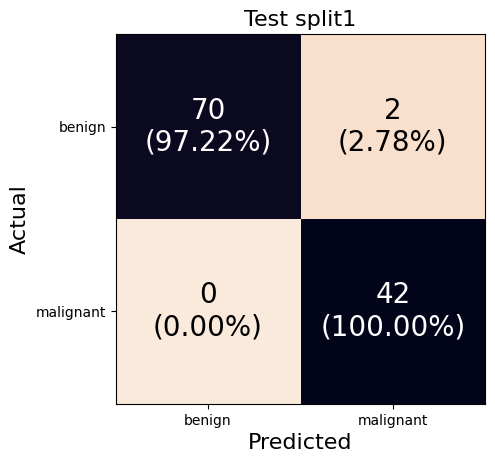

---------------------------------------
AUC validate: 97.63%
AUC test: 99.74%


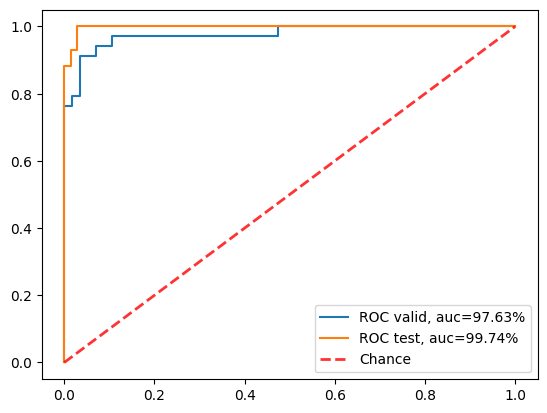

false_predict
The most important feature in split split1 is: area_se


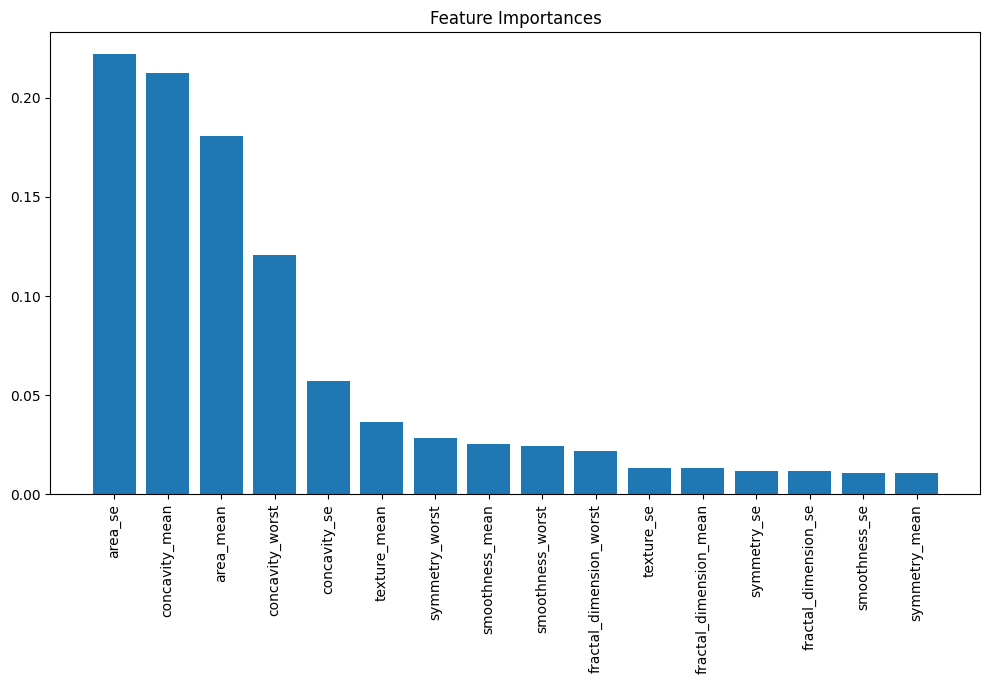

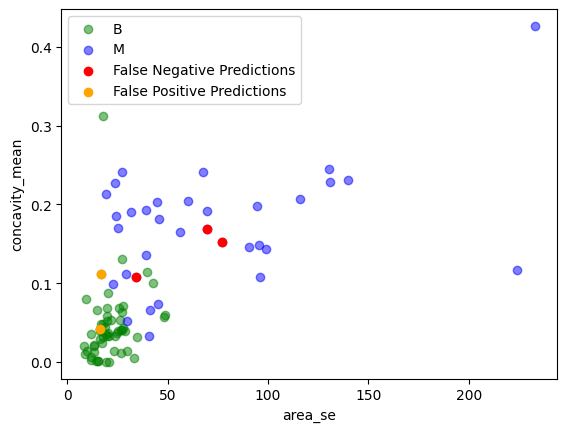

In [3]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

In [4]:
# false_predict("split1")

# split 2

../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.710000
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


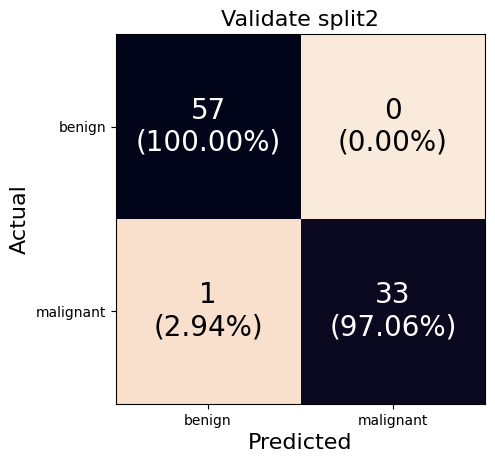

################# test set ##################
Best Threshold=0.388333
FPR: 0.0278
TPR: 1.0000
Confusion Matrix
----------------
[[70  2]
 [ 0 42]] 

----------------
split2
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 98.25%
Precision: 95.45%
Sensitivity: 100.00%
Precision: 95.45%
F1: 97.67%


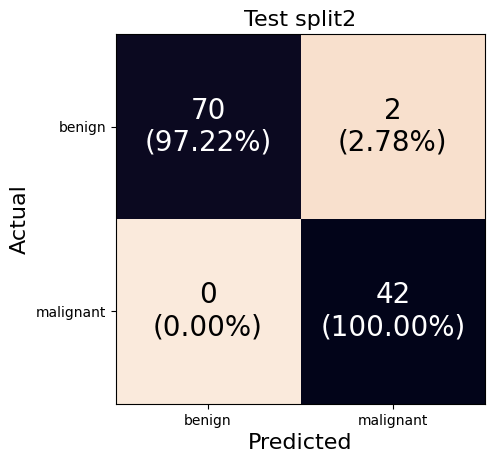

---------------------------------------
AUC validate: 99.12%
AUC test: 99.80%


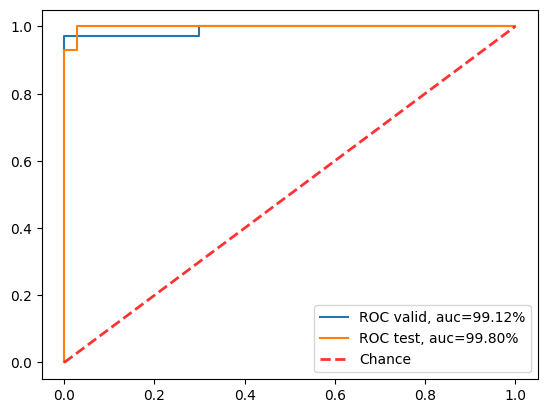

false_predict
The most important feature in split split2 is: area_mean


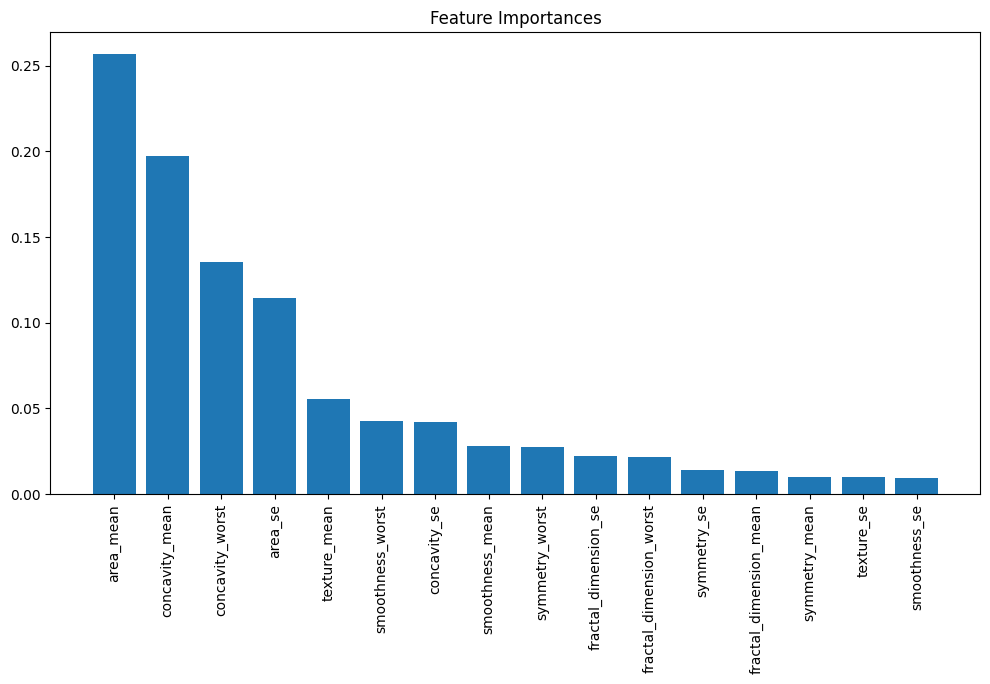

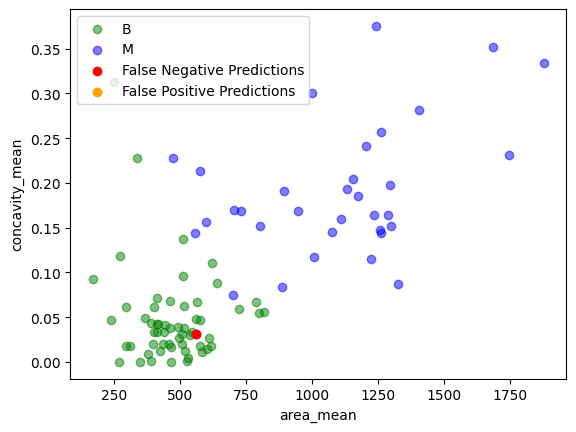

In [5]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

# split 3

../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.525833
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


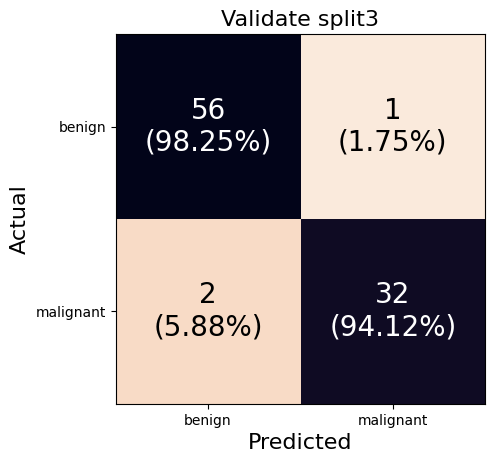

################# test set ##################
Best Threshold=0.359167
FPR: 0.0000
TPR: 1.0000
Confusion Matrix
----------------
[[72  0]
 [ 0 42]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


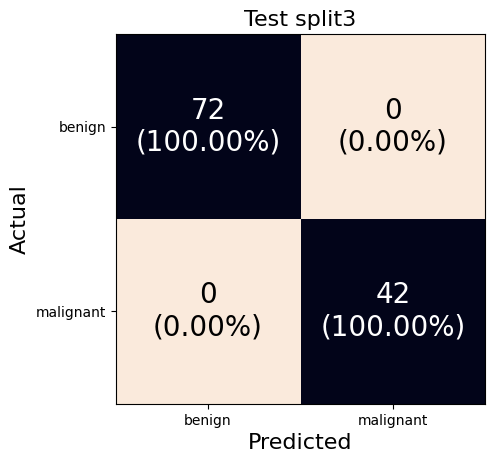

---------------------------------------
AUC validate: 99.07%
AUC test: 100.00%


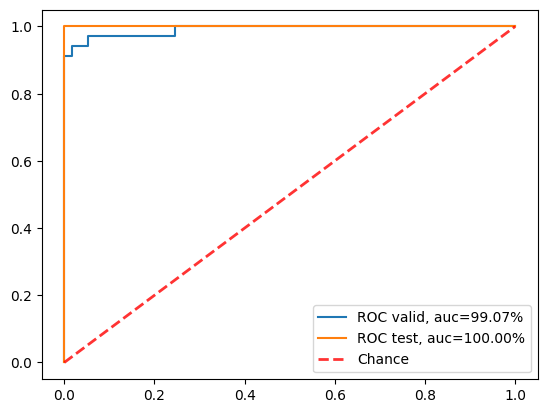

false_predict
The most important feature in split split3 is: area_mean


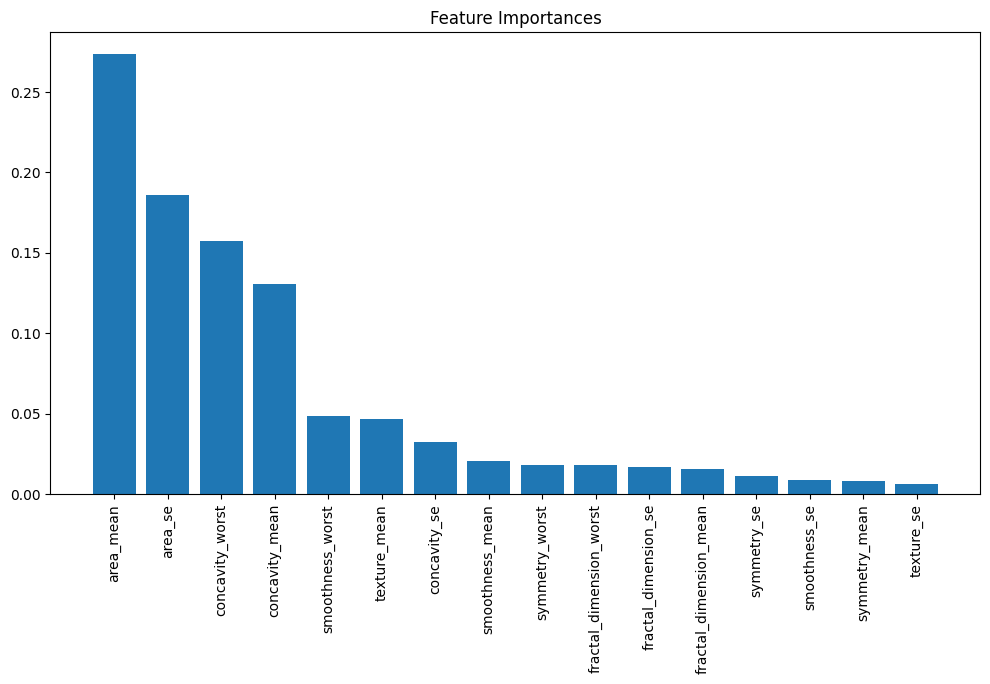

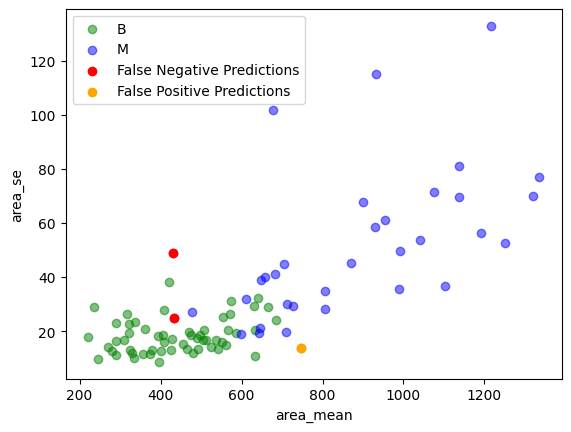

In [6]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

# split 4

../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.625000
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split4
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


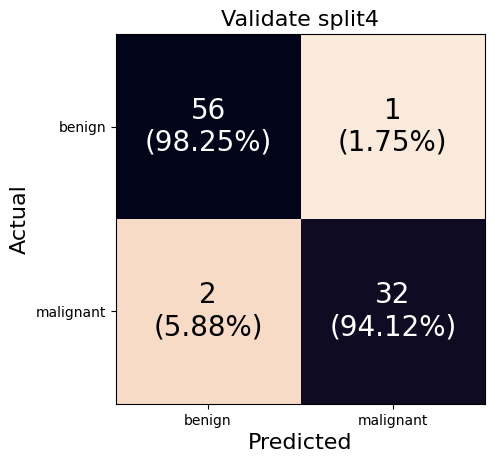

################# test set ##################
Best Threshold=0.304167
FPR: 0.0556
TPR: 1.0000
Confusion Matrix
----------------
[[68  4]
 [ 0 42]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 94.44%
Accuracy: 96.49%
Precision: 91.30%
Sensitivity: 100.00%
Precision: 91.30%
F1: 95.45%


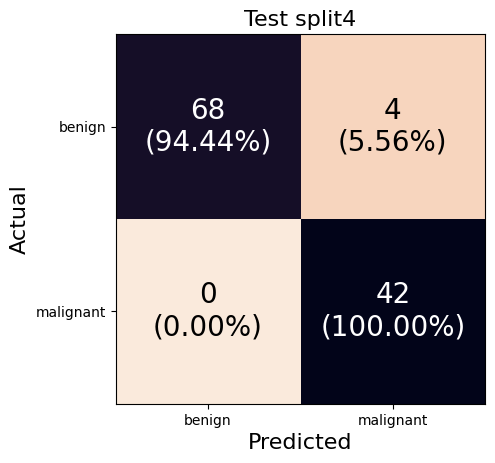

---------------------------------------
AUC validate: 99.07%
AUC test: 99.37%


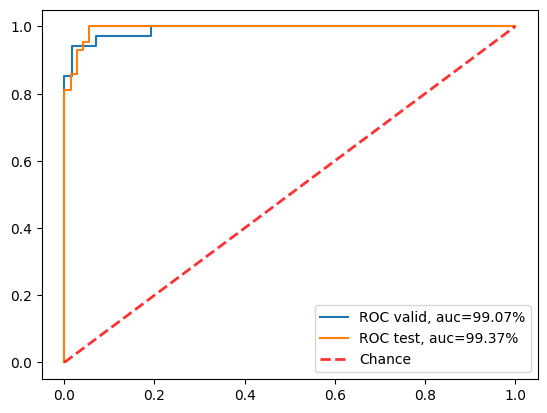

false_predict
The most important feature in split split4 is: area_mean


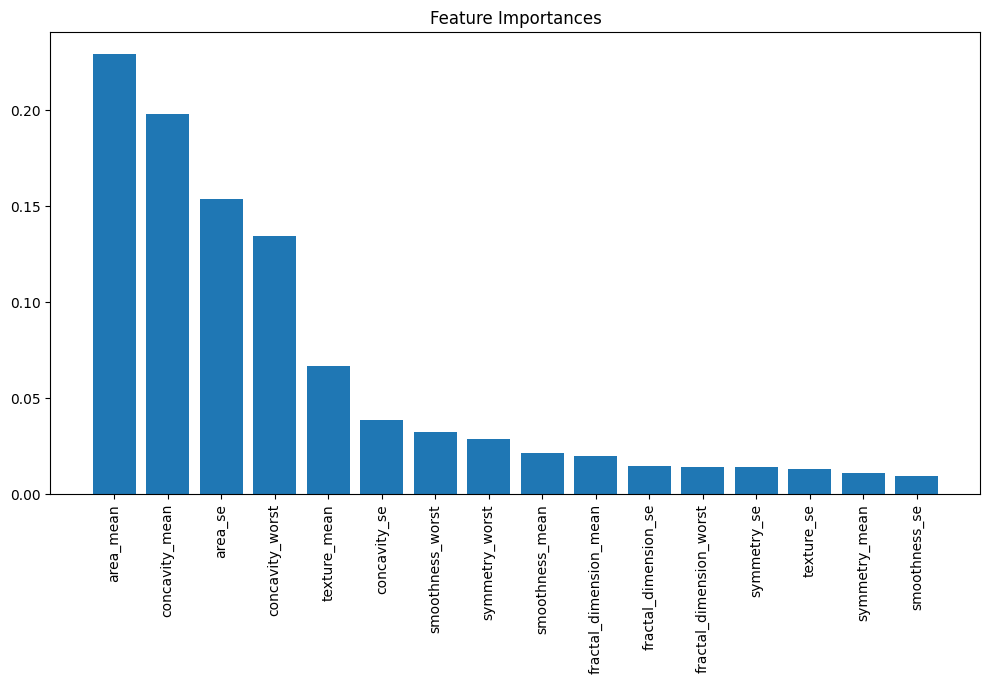

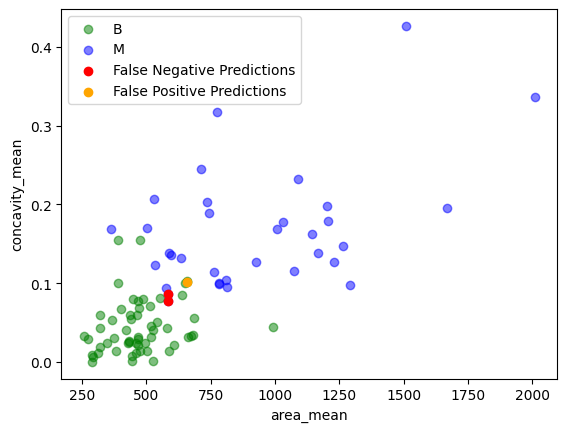

In [7]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

# split 5

../kitt/DATA_progress3_new//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
############## validate set ################
Best Threshold=0.185000
FPR: 0.1228
TPR: 0.9706
Confusion Matrix
----------------
[[50  7]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 87.72%
Accuracy: 91.21%
Precision: 82.50%
Sensitivity: 97.06%
Precision: 82.50%
F1: 89.19%


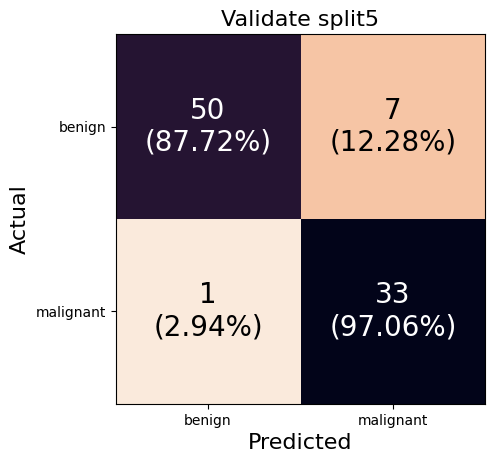

################# test set ##################
Best Threshold=0.465833
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


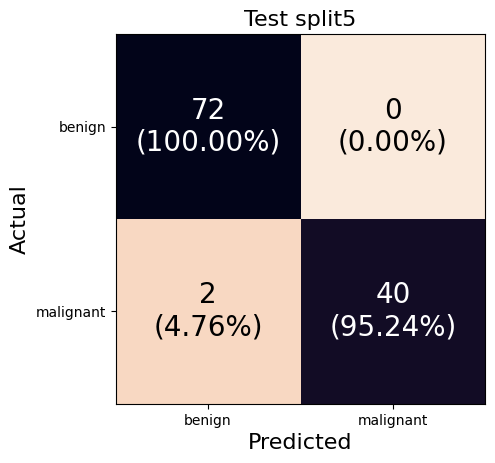

---------------------------------------
AUC validate: 97.99%
AUC test: 99.50%


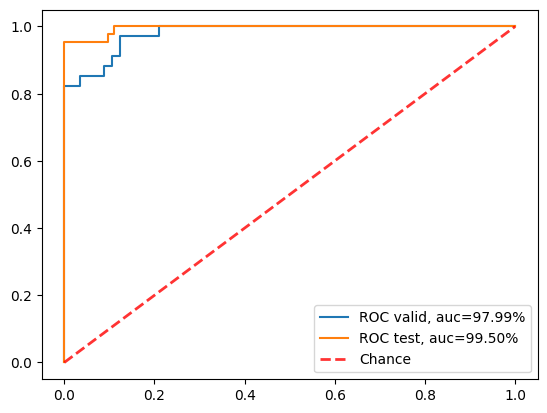

false_predict
The most important feature in split split5 is: concavity_mean


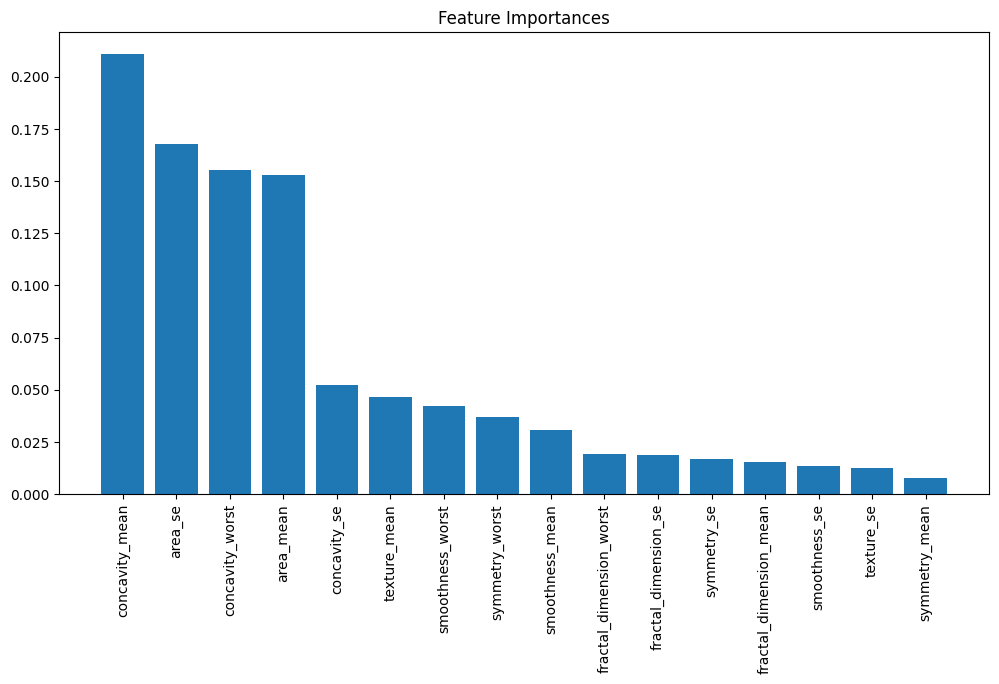

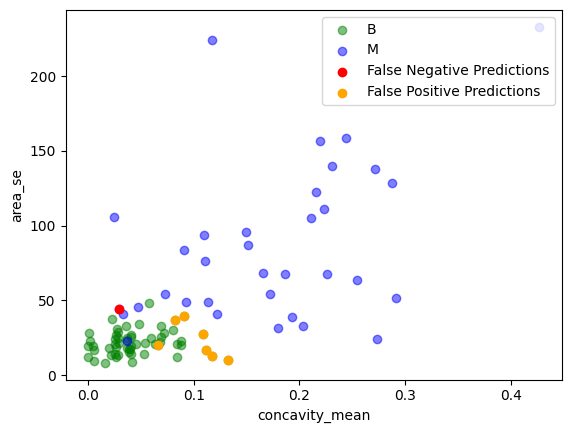

In [8]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

# Overall

param2
split1
Sensitivity: 91.18%
Specificity: 96.49%
Accuracy: 94.51%
Precision: 93.94%
Sensitivity: 91.18%
Precision: 93.94%
F1: 92.54%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split4
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split5
Sensitivity: 97.06%
Specificity: 87.72%
Accuracy: 91.21%
Precision: 82.50%
Sensitivity: 97.06%
Precision: 82.50%
F1: 89.19%

overall
sensitivity: 94.71 ± 2.46%
specificity: 96.14 ± 4.87%
accuracy: 95.60 ± 2.91%
precision: 94.08 ± 6.82%
f1_score: 94.26 ± 3.53%


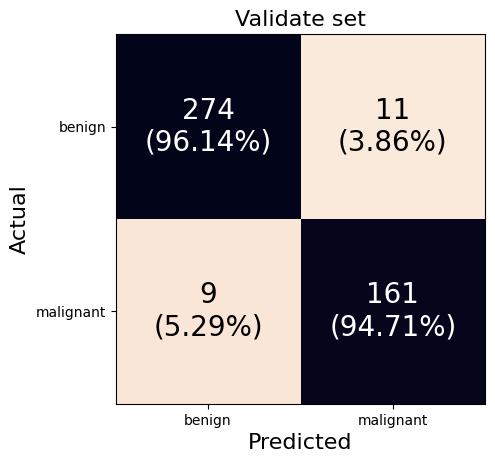

AUC2: 9857.59 ± 71.37%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.547500
FPR: 0.0351
TPR: 0.9118
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.710000
FPR: 0.0000
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.525833
FPR: 0.0175
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

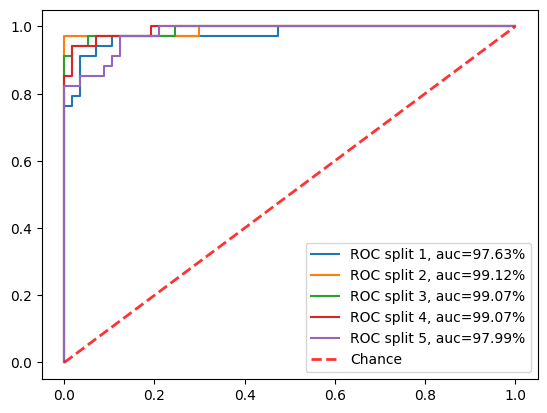

In [9]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC2",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)
ROC_split(2)